# Homework 2 - Hypothesis Testing

Homework setup such as imports are mentioned below.

In [1848]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Part 1

## Part 2

### Task 1: Import the Data
Use the pandas.read_csv() function to import the dataset. The data is contained in two files: realEstate1.csv and realEstate2.csv. After you import these files separately, concatenate them into one big dataframe. This pandas dataframe will be used for data exploration and linear regression.

In [1849]:
# Import Data
re1 = pd.read_csv("realEstate1.csv")
re2 = pd.read_csv("realEstate2.csv")

# Concatenate Dataframe
data_list = [re1, re2]
df = pd.concat(data_list, ignore_index=True)
display(df)

,ListNo,Access,AdditInfo,Acres,ListAgt,AirType,Amenities,Area,BackDim,Basemnt,...,WinEvp1,WinEvp2,WinEvp3,WinEvp4,Window,WithDrDt,YearBlt,Zip,Zoning,LastMod
0,1397571,Concrete,NaN,0.29,Liz Slager,Central Air; Electric,See Remarks; Cable Tv Available; Cable Tv Wire...,101,0.0,Daylight; Entrance; Full; Walkout,...,0,0,0,0,Blinds,00/00/0000,1998,84103,NaN,08/29/2016
1,1394021,Asphalt,NaN,0.01,Angela Carlson,Central Air; Electric,Cable Tv Available; Electric Dryer Hookup,101,0.0,None/Crawl Space,...,0,0,0,0,Blinds; Plantation Shutters,00/00/0000,1965,84103,RES,08/22/2016
2,1393604,NaN,NaN,0.11,Rachel Kitterer,Central Air; Electric,Cable Tv Wired; Electric Dryer Hookup,101,0.0,Full,...,0,0,0,0,Blinds; Plantation Shutters,00/00/0000,1940,84103,NaN,08/29/2016
3,1393602,Concrete,NaN,0.14,Rachel Kitterer,Central Air; Electric,Cable Tv Wired; Electric Dryer Hookup,101,0.0,Full,...,0,0,0,0,Blinds,00/00/0000,1940,84103,NaN,08/29/2016
4,1393829,Asphalt,NaN,0.01,T. Carter Maudsley,Central Air; Electric,Cable Tv Wired,101,0.0,None/Crawl Space,...,0,0,0,0,NaN,00/00/0000,1969,84103,NaN,08/18/2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,1277128,Concrete,NaN,0.28,Liz Slager,Central Air; Electric,Cable Tv Wired; Electric Dryer Hookup; Exercis...,101,0.0,Partial; Walkout,...,0,0,0,0,Blinds; Full,00/00/0000,1978,84103,RES,10/06/2015
344,1265274,Concrete,NaN,0.01,PATRICK WISCOMBE,Central Air; Electric,Electric Dryer Hookup; Exercise Room; Gas Drye...,101,0.0,None/Crawl Space,...,0,0,0,0,Full; Shades,00/00/0000,1979,84103,NaN,05/24/2016
345,1241781,Concrete,NaN,0.00,Jacqui Johnston,Central Air; Electric,Exercise Room; Swimming Pool,101,0.0,None/Crawl Space,...,0,0,0,0,Draperies,00/00/0000,1976,84103,CONDO,10/29/2015
346,1238399,NaN,NaN,0.07,Grady Kohler,Central Air; Electric,Cable Tv Available; Electric Dryer Hookup,101,0.0,None/Crawl Space,...,0,0,0,0,NaN,00/00/0000,1886,84103,NaN,09/11/2015


### Task 2: Clean the Data
There are 206 different variables associated with each of the 348 houses in this dataset. Skim them and try to get a rough understanding of what information this dataset contains. If you've never seen a real estate listing before, you might take a look at one on this website (Links to an external site.) to get a better sense of the meanings of the column headers in the dataset.

Only keep houses with List Price between 200,000 and 1,000,000 dollars. This is an arbitrary choice and we realize that some of you are high rollers, but for our purposes we'll consider the others as outliers.

Remove columns that you don't think contribute to the value of the house. This is a personal decision - what attributes of a house are important to you? You should at least keep the following variables since the questions below will use them: ['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'LstPrice', 'Patio', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']

Check the datatypes and convert any numbers that were read as strings to numerical values. (Hint: You can use str.replace() (Links to an external site.) to work with strings.) If there are any categorical values you're interested in, then you should convert them to numerical values as we saw in the notes (the get_dummies function may help). In particular,

Convert 'TotSqf' to an integer.
Add a new column titled Prop_Type_SingleFamily that is set to 0 if the i-th listing is a condo or townhouse, or 1 if the i-th listing is a single family house.
Remove the listings with erroneous 'Longitude' (one has Longitude = 0) and 'Taxes' values (two have unreasonably large values).

In [1850]:
df = df[(df.LstPrice >= 200000) & (df.LstPrice <= 1000000)] # Filter Data
df.reset_index(inplace=True, drop=True) # Fix index

# Filter columns
df = df[['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'LstPrice', 'Patio', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']]

# Fix dtypes
df.TotSqf = pd.Series(df.TotSqf).str.replace(',', '', regex=True)
df.TotSqf = pd.to_numeric(df.TotSqf)

Prop_Type_SingleFamily_data = []

for i in df['PropType']:
    if i == 'Single Family':
        Prop_Type_SingleFamily_data.append(1)
    else:
        Prop_Type_SingleFamily_data.append(0)

df['Prop_Type_SingleFamily'] = Prop_Type_SingleFamily_data

df = df[(df.Longitude != 0) & (df.Taxes <= 10000) & (df.Taxes >= 1000)] # Filter Data
df.reset_index(inplace=True, drop=True) # Fix index
df

,Acres,Deck,GaragCap,Latitude,Longitude,LstPrice,Patio,PkgSpacs,PropType,SoldPrice,Taxes,TotBed,TotBth,TotSqf,YearBlt,Prop_Type_SingleFamily
0,0.29,1,3,40.779524,-111.893542,725000,1,0,Single Family,752000,7244,4.0,5.0,5415,1998,1
1,0.01,0,0,40.773243,-111.883291,205000,0,0,Condo,205000,1431,2.0,1.0,924,1965,0
2,0.11,0,0,40.773972,-111.867470,390000,1,0,Single Family,390000,1816,3.0,1.0,1702,1940,1
3,0.14,0,1,40.783009,-111.872100,445000,1,3,Single Family,443000,3260,3.0,2.0,1756,1940,1
4,0.01,0,2,40.771693,-111.886951,339000,0,2,Condo,334000,2141,3.0,2.0,1368,1976,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,0.28,1,3,40.782933,-111.851143,995000,0,6,Single Family,949000,6658,6.0,4.0,5740,1978,1
250,0.01,0,2,40.770904,-111.886201,349999,2,2,Condo,340000,1877,2.0,2.0,1473,1979,0
251,0.00,0,0,40.773843,-111.891911,249900,0,0,Condo,231000,2812,2.0,2.0,1385,1976,0
252,0.07,0,1,40.772835,-111.854867,330000,0,0,Single Family,310000,2079,5.0,3.0,2094,1886,1


### Task 3: Exploratory Data Analysis
Explore the dataset. Write a short description of the dataset describing the number of items, the number of variables and check to see if the values are reasonable.

In [1851]:
df.describe()

,Acres,Deck,GaragCap,Latitude,Longitude,LstPrice,Patio,PkgSpacs,SoldPrice,Taxes,TotBed,TotBth,TotSqf,YearBlt,Prop_Type_SingleFamily
count,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000
mean,0.132323,0.681102,1.283465,40.777405,-111.875359,468331.744094,0.633858,1.035433,455283.622047,3083.917323,3.228346,2.543307,2503.708661,1940.468504,0.748031
std,0.124623,0.798143,0.973138,0.005784,0.013801,200026.738539,0.685677,1.588846,189861.027774,1664.854395,1.242775,1.076195,1223.088956,35.887354,0.435000
min,0.000000,0.000000,0.000000,40.769424,-111.913645,200000.000000,0.000000,0.000000,190000.000000,1100.000000,1.000000,0.000000,844.000000,1852.000000,0.000000
25%,0.050000,0.000000,0.250000,40.772358,-111.886521,315000.000000,0.000000,0.000000,310000.000000,1897.000000,2.000000,2.000000,1550.500000,1908.000000,0.250000
50%,0.110000,1.000000,1.000000,40.775630,-111.874036,419000.000000,1.000000,0.000000,401500.000000,2472.000000,3.000000,2.000000,2272.500000,1937.000000,1.000000
75%,0.160000,1.000000,2.000000,40.781845,-111.865921,598000.000000,1.000000,2.000000,570000.000000,3861.750000,4.000000,3.000000,3081.000000,1976.000000,1.000000
max,0.690000,5.000000,5.000000,40.791059,-111.843083,1000000.000000,3.000000,8.000000,980000.000000,9205.000000,8.000000,7.000000,7508.000000,2015.000000,1.000000


The dataset has exactly 254 entries and has 14 variables. I found that there was an entry with tax = 1, so I filtered the data above in Task 2, to have the lowest tax value as 1000. Apart from that the data seems to be pretty reasonable.

Make a bar chart showing the breakdown of the different types of houses (single family, townhouse, condo).

<AxesSubplot:>

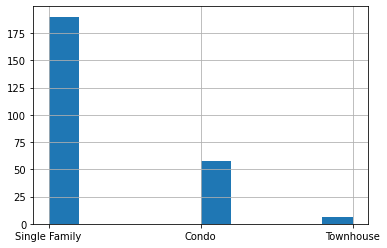

In [1852]:
# df.groupby('PropType').nunique().plot.bar()
df['PropType'].hist()

Compute the correlation matrix and use a heat map to visualize the correlation coefficients.

<AxesSubplot:>

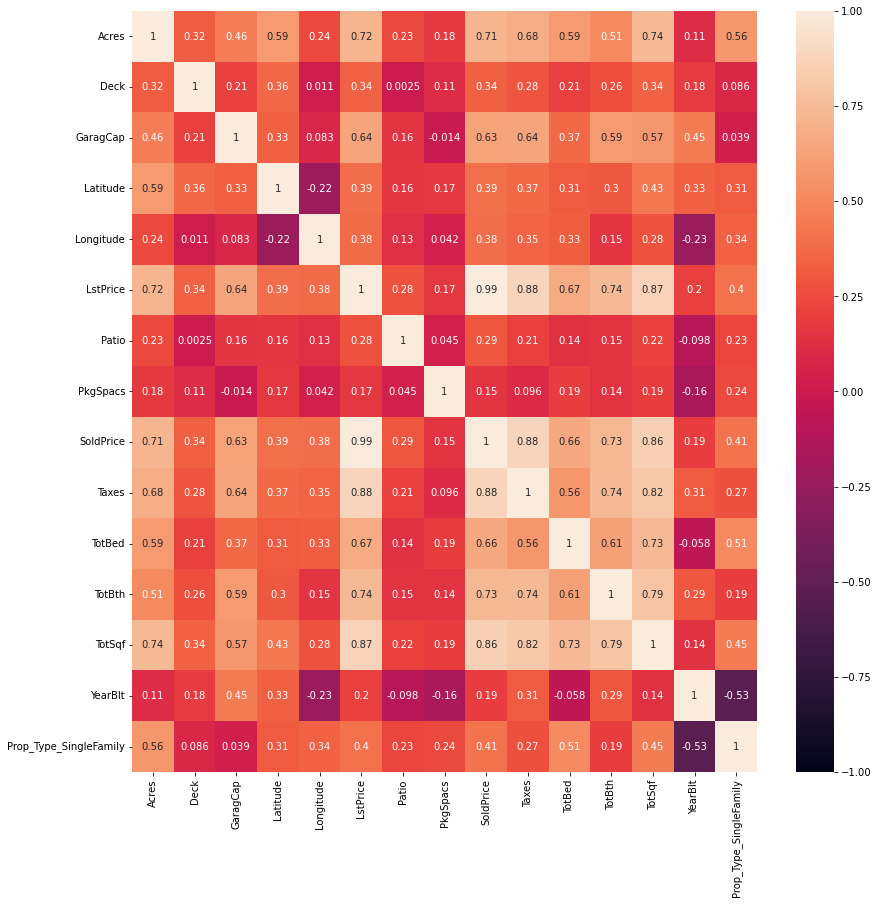

In [1853]:
corrM = df.corr()
plt.figure(figsize=(14,14))
sns.heatmap(corrM, annot=True, vmin=-1, vmax=1)

Make a scatter plot matrix to visualize the correlations. For the plot, only use a subset of the columns: ['Acres', 'LstPrice', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt'].

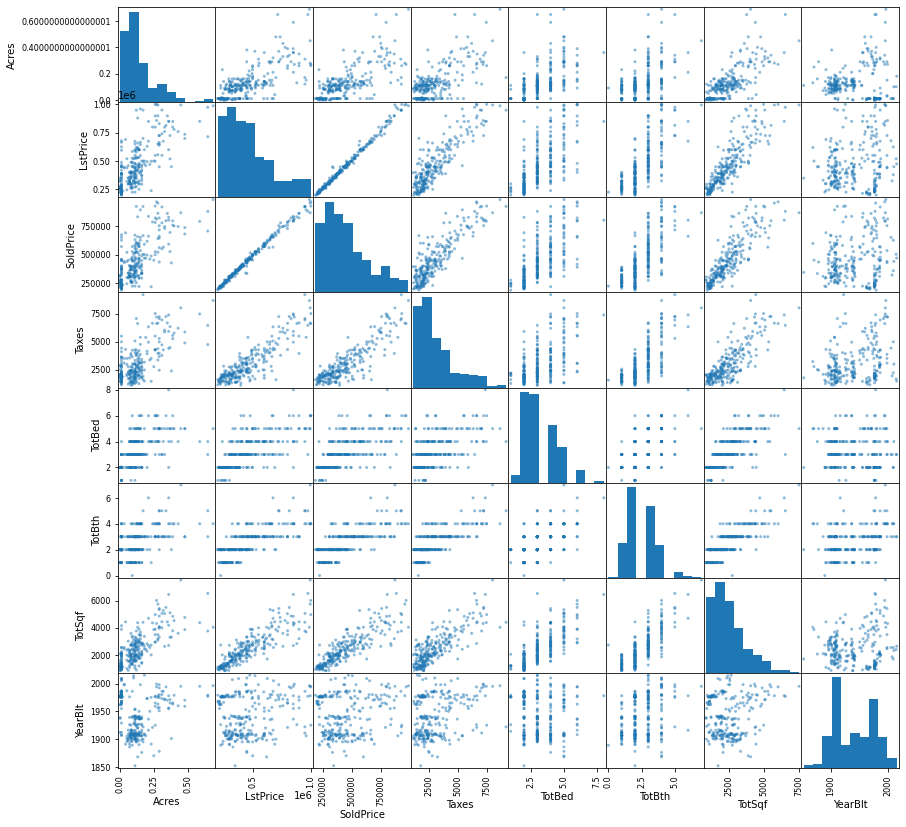

In [1854]:

pd.plotting.scatter_matrix(df[['Acres', 'LstPrice', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']], figsize=[14,14])

plt.show()

Sold prices, list prices and taxes are strongly correlated. The size of the property, i.e. 'TotSqf' is averagely correlated to sold prices, list prices and taxes. Total beds and total baths is roughly correlated with the prices, taxes and square footage of the property. This means that as the listing price goes up, all the other columns mentioned above also go up more or less.

### Task 4: Geospatial Plot
Two of the variables are the latitude and longitude of each listing. Salt Lake City is on this nice east-west, north south grid, so even a simple plot of latitude vs longitude makes sense. Create a scatterplot of these two variables. Use color to indicate the price of the house. How does the price depend on the house location?

Bonus: If you can, overlay the scatterplot on a map of the city. (This is challenging, and we didn't teach you how to do it, so you should do the other parts of the assignment first.)

What can you say about the relation between the location and the house price?

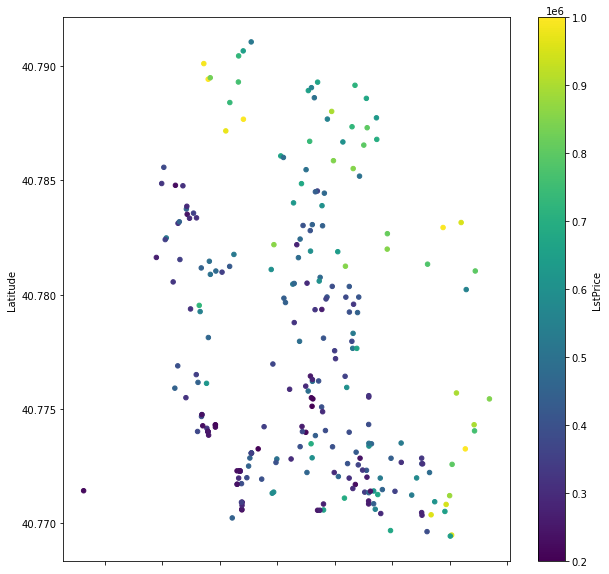

In [1855]:
geoplot = df.plot(x='Longitude', y='Latitude', c='LstPrice', colormap='viridis', figsize=[10,10], kind='scatter')
# For some reason, when I add color to this graph, it makes the x-axis label invisible.

It seems like the real estate prices increase as we go North mostly, but also East. The prices go down as we get farther from North and East side of Salt Lake City.

### Task 5: Simple Linear Regression
Make sure to `pip3 install statsmodels`.

Use the 'ols' function from the statsmodels (Links to an external site.) package to regress the Sold price on some of the other variables. Your model should be of the form Sold Price = beta_0 + beta_1 * x, where x is one of the other variables.

You'll find that the best predictor of sold price is the list price. Report the R-squared value for this model (SoldPrice ~ LstPrice) and give an interpretation for its meaning. Also give an interpretation of beta_1 for this model. Make a plot of list price vs. sold price and overlay the prediction coming from your regression model.

In [1856]:
result = smf.ols(formula='SoldPrice ~ TotBed', data=df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     194.6
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           3.63e-33
Time:                        18:29:36   Log-Likelihood:                -3374.4
No. Observations:                 254   AIC:                             6753.
Df Residuals:                     252   BIC:                             6760.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.297e+05    2.5e+04      5.188      0.0

In [1857]:
result = smf.ols(formula='SoldPrice ~ TotSqf', data=df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     699.6
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           1.15e-74
Time:                        18:29:36   Log-Likelihood:                -3278.3
No. Observations:                 254   AIC:                             6561.
Df Residuals:                     252   BIC:                             6568.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.22e+05    1.4e+04      8.707      0.0

In [1858]:
result = smf.ols(formula='SoldPrice ~ Taxes', data=df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     825.0
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           1.89e-81
Time:                        18:29:36   Log-Likelihood:                -3262.6
No. Observations:                 254   AIC:                             6529.
Df Residuals:                     252   BIC:                             6536.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.475e+05   1.22e+04     12.115      0.0

In [1859]:
result = smf.ols(formula='SoldPrice ~ LstPrice', data=df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 2.491e+04
Date:                Thu, 16 Jun 2022   Prob (F-statistic):          6.09e-254
Time:                        18:29:36   Log-Likelihood:                -2862.4
No. Observations:                 254   AIC:                             5729.
Df Residuals:                     252   BIC:                             5736.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.298e+04   3046.346      4.262      0.0

Based on `List Price ~ Sold Price` model, the r-squared value, i.e. `0.99` signifies that the model fits the data well. It means that the List Price is strongly correlated to Sold Price. Based on Beta_1 of this model, i.e. `0.94`, it signifies that the seller is selling the property a little less than what it was listed for.

<AxesSubplot:xlabel='LstPrice', ylabel='SoldPrice'>

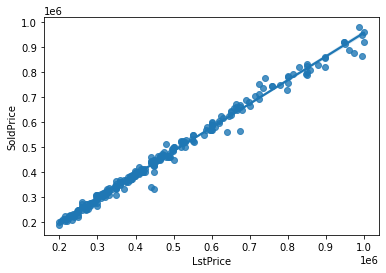

In [1860]:
sns.regplot(x='LstPrice', y='SoldPrice', data=df)

### Task 6: Multiple Regression
Develop a multilinear regression model for house prices in this neighborhood. We could use this to come up with a list price for houses coming on the market, so do not include the list price in your model and, for now, ignore the categorical variable Prop_Type. Your model should be of the form:

Sold Price = beta_0 + beta_1 * x_1 + beta_2 * x_2 + ... + beta_n * x_n

where x_i are predictive variables. Which variables are the best predictors for the Sold Price?

In [1861]:
result = smf.ols(formula='SoldPrice ~ TotSqf + GaragCap + Longitude + Acres', data=df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     248.1
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           1.38e-85
Time:                        18:29:36   Log-Likelihood:                -3243.0
No. Observations:                 254   AIC:                             6496.
Df Residuals:                     249   BIC:                             6514.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.599e+08   4.58e+07      5.675      0.0

Iteratively, having all the variables excluding the ones mentioned in the assignment, I found out that Total Sq. Ft., Garage Capacity, Longitude and Acres were the best variables for an accurate model. I determined this by checking the p-values of variables. Based on my research, a variable p-value should be under 0.005.

Q: Often the price per square foot for a house is advertised. Is this what the coefficient for TotSqf is measuring? Provide an interpretation for the coefficient for TotSqf.
A: Yes, that is precisely what the TotSqf coefficient is measuring. For adding each sq. ft. the price will increase by about 90.21 dollars.

Q: Estimate the value that each Garage space adds to a house.
A: Based on my model, each garage space will add about 42,030 dollars to a house. I am 79.9% sure about my answer.

Q: Does latitude or longitude have an impact on house price? Explain.
A: To a certain extent, longitude does affect the price. This data set doesn't have enough information that would be considered valid for this model, but based on the my intuition yes it will affect it as well, but not as much as longitude. I personally think that based on the coefficient of longitude, it means the for every increment degree of Longitude, the price increases by 2.3 million, which is not true in real life scenario as once we cross a point moving North, the prices will start to fall again. But if we hypothetically have another variable that can determine the boundaries of Salt Lake and compare it with Longitude, then it will be a good variable to have. But in this case, with the current variables, I think having Longitude could be a bad option if trying to predict a price outside the data set range. But if used for predicting values within the range of data, longitude is a good variable as it implies that as you get closer to downtown, the prices will increase.

Q: If we wanted to start a 'house flipping' company, we'd have to be able to do a better job of predicting the sold price than the list price does. How does your model compare?
A: Based on my model, the only way we can make a profit is by increasing garage space. The other factors cannot be changes being a house flipper in my understanding as you cannot control the other factors such as acres, sq. ft., etc. A house flipper just fixes up the existing property. The probability of this being accurate is just 79.9%.

### Task 7: Incorporating a Categorical Variable
From the first model, it would appear that Property type is significant in predicting the sold price. On the other hand, the second model indicates that when you take into account total square footage, property type is no longer predictive. Explain this. (Hint: there is a confounder lurking here.) Make a scatterplot of TotSqf vs. SoldPrice where the house types are colored differently to illustrate your explanation

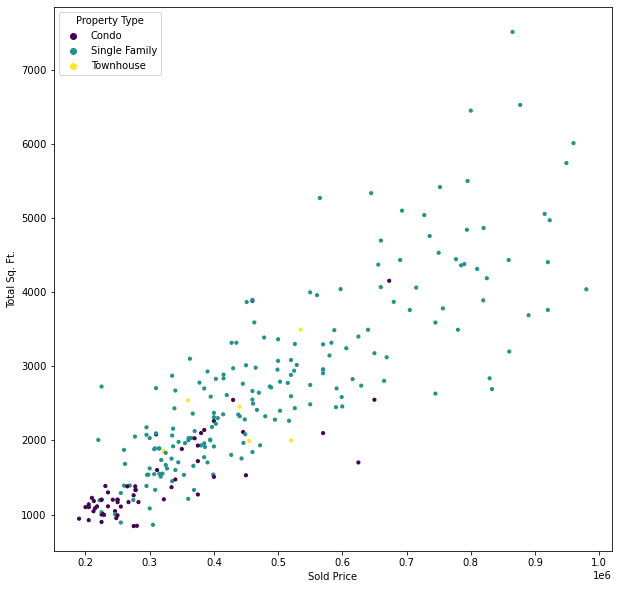

In [1862]:
color_dict = {'Single Family': 'red', 'Condo': 'blue', 'Townhouse': 'green'}
# fig, ax = plt.subplots()
PropType = df.PropType.astype('category').cat.codes
plt.figure(figsize=(10,10))
scatter = plt.scatter(y=df.TotSqf, x=df.SoldPrice, c=PropType, s=10)
plt.xlabel('Sold Price')
plt.ylabel('Total Sq. Ft.')
prop_names = ['Condo', 'Single Family', 'Townhouse']
plt.legend(handles=scatter.legend_elements()[0],
           labels=prop_names,
           title="Property Type")
# df.plot(x='SoldPrice', y='TotSqf', c=[color_dict[i] for i in df.PropType], colormap='viridis', figsize=[10,10], kind='scatter')
#plt.legend(['Single Family', 'Condo', 'Townhouse'])
# For some reason, when I add color to this graph, it makes the x-axis label invisible.

Property type is no longer predictable because adding Total sq. ft. variables causes a spurious correlation. Sold price goes up regardless of the property type as the sq. ft. increases. There are not enough condos or townhouses in the range of comparison, therefore it can't be confidently assumed that the property will affect the regression.